Processing

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import pytesseract
from skimage import io, img_as_ubyte
from skimage.transform import rotate
import cv2
from deskew import determine_skew
from concurrent.futures import ThreadPoolExecutor, as_completed

In [5]:
def filter_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(src=image, ddepth=-1, kernel=kernel)


def resize_image(image):
    return cv2.resize(image, (1000, 1000))

def correct_rotation(image, confidence_threshold: int = 10):
    pil_image = Image.fromarray(image)
    osd = pytesseract.image_to_osd(pil_image, output_type=pytesseract.Output.DICT)
    rotate_angle = osd['rotate']
    orientation_conf = osd['orientation_conf']
    
    if orientation_conf < confidence_threshold:
        rotate_angle = 0
    
    corrected_pil_image = pil_image.rotate(-rotate_angle, expand=True)
    return np.array(corrected_pil_image), osd

def deskew(image, resize: bool = True):
    angle = determine_skew(image)
    rotated = rotate(image, angle, resize=resize)
    return img_as_ubyte(np.clip(rotated, 0, 1))

def has_enough_text(image, word_threshold: int = 10):
    text = pytesseract.image_to_string(Image.fromarray(image))
    return len(text.strip().split()) > word_threshold

def has_too_many_black_pixels(image, black_pixel_threshold: float = 0.5, threshold_level: int = 10):
    pixels = np.asarray(image)
    black_pixel_ratio = np.sum(pixels < threshold_level) / pixels.size
    return black_pixel_ratio > black_pixel_threshold

In [6]:
def process_image(image_file, output_directory):
    output_file = os.path.join(output_directory, os.path.basename(image_file))
    try:
        image = io.imread(image_file)
        if has_enough_text(image) and not has_too_many_black_pixels(image):
            try:
                image, osd = correct_rotation(image)
            except Exception:
                pass
            image = deskew(image)
            image = resize_image(image)
            #image = filter_image(image)
            Image.fromarray(image).save(output_file)
            return True, None, output_file
        else:
            Image.fromarray(image).save(output_file)
            return False, "Filtered", output_file
    except Exception as e:
        return False, str(e), None

def process_images(df_all, output_directory: str, batch_size: int, max_images: int):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    image_files = df_all['image_path'].tolist()[:max_images]
    processed_images = []

    with ThreadPoolExecutor(max_workers=batch_size) as executor:
        futures = {executor.submit(process_image, image_file, output_directory): image_file for image_file in image_files}
        for future in as_completed(futures):
            success, reason, output_file = future.result()
            if output_file:
                processed_images.append(output_file)

    print(f"Processed {len(processed_images)} images.")
    return processed_images

def match_labels(processed_images, df_all, output_directory):
    # Filter out None values from processed_images
    processed_images = [image for image in processed_images if image is not None]
    
    processed_file_names = [os.path.basename(image) for image in processed_images]
    processed_df = df_all[df_all['image_path'].apply(lambda x: os.path.basename(x)).isin(processed_file_names)].copy()
    processed_df['processed_image_path'] = processed_df['image_path'].apply(lambda x: os.path.join(output_directory, os.path.basename(x)))
    return processed_df


In [23]:
# Configuration
image_path = './../data/raw/selected'
output_directory = './../data/raw/correct_selected'
batch_size = 1000
max_images = 400000
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load and combine DataFrames
df_train = pd.read_csv('./../data/raw/labels/train.txt', sep = " ", names = ['Image','Label'])
df_val = pd.read_csv('./../data/raw/labels/val.txt', sep = " ", names = ['Image','Label'])
display(df_val)
df_test = pd.read_csv('./../data/raw/labels/test.txt', sep = " ", names = ['Image','Label'])
display(df_test)
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)
print(df_all)
df_all.columns = ['Image','Label']
df_all['Image'] = df_all['Image'].apply(lambda x: str(x).split('/')[-1])
print(df_all)
df_all['Image'] = df_all['Image'].astype(str)
df_all['Label'] = df_all['Label'].astype(int)
df_all['image_path'] = df_all['Image'].apply(lambda x: os.path.join(image_path, x))

processed_images = process_images(df_all, output_directory, batch_size, max_images)
processed_df = match_labels(processed_images, df_all, output_directory)

# Save the DataFrame to CSV
processed_df.to_csv('processed_images_paths.csv', index=False)


,Image,Label
0,imagesg/g/t/h/gth35e00/2024525661.tif,11
1,imagesi/i/y/k/iyk38c00/512015827+-5827.tif,0
2,imagesr/r/r/e/rre21e00/87103403.tif,0
3,imagesk/k/s/u/ksu44c00/03636607.tif,4
4,imagesr/r/a/i/rai09d00/50437856-7857.tif,14
...,...,...
39995,imageso/o/u/k/ouk93f00/0013006838.tif,10
39996,imagesf/f/f/b/ffb52c00/2074103881.tif,11
39997,imagesg/g/h/b/ghb11f00/0001251052.tif,15
39998,imagesl/l/c/k/lck71f00/2016003416.tif,9


,Image,Label
0,imagesr/r/g/e/rge31d00/503210033+-0034.tif,3
1,imagesc/c/e/j/cej80d00/517306722+-6724.tif,3
2,imagesm/m/r/r/mrr36d00/50603620-3621.tif,14
3,imagesg/g/t/u/gtu29c00/2084573574a.tif,2
4,imagesh/h/o/f/hof08d00/2071783492.tif,9
...,...,...
39995,imagesx/x/a/t/xat14f00/0000371340.tif,15
39996,imagesk/k/v/w/kvw25f00/0060211544.tif,12
39997,imagesq/q/e/q/qeq21a00/0071019136.tif,8
39998,imagesw/w/b/v/wbv80e00/88131792.tif,11


                                                   Image  Label
0                    imagesq/q/o/c/qoc54c00/80035521.tif     15
1                   imagese/e/w/c/ewc23d00/513280028.tif      1
2                  imagesw/w/b/t/wbt26e00/2053453161.tif      7
3       imagesm/m/k/m/mkm05e00/2040792992_2040792994.tif     10
4             imageso/o/e/x/oex80d00/522787731+-7732.tif      3
...                                                  ...    ...
399995             imagesx/x/a/t/xat14f00/0000371340.tif     15
399996             imagesk/k/v/w/kvw25f00/0060211544.tif     12
399997             imagesq/q/e/q/qeq21a00/0071019136.tif      8
399998               imagesw/w/b/v/wbv80e00/88131792.tif     11
399999  imagest/t/f/q/tfq58e00/2022219448_2022219457.tif     10

[400000 rows x 2 columns]
                            Image  Label
0                    80035521.tif     15
1                   513280028.tif      1
2                  2053453161.tif      7
3       2040792992_2040792994.tif     10


<tifffile.TiffPages @85476> invalid offset to first page 85476


Processed 20015 images.


In [ ]:


# Configuration
image_path = 'C:/Users/HP/Desktop/Projet/RVL_dataset/'
output_directory = 'C:/Users/HP/Desktop/projet/correct_RVL_dataset'
batch_size = 1000
max_images = 20000
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load and combine DataFrames
df_train = pd.read_csv('C:/Users/HP/Desktop/Projet/RVL_dataset/train.csv')
df_val = pd.read_csv('C:/Users/HP/Desktop/Projet/RVL_dataset/validation.csv')
df_test = pd.read_csv('C:/Users/HP/Desktop/Projet/RVL_dataset/test.csv')
df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

df_all['Image'] = df_all['Image'].astype(str)
df_all['Label'] = df_all['Label'].astype(int)
df_all['image_path'] = df_all['Image'].apply(lambda x: os.path.join(image_path, x))

processed_images = process_images(df_all, output_directory, batch_size, max_images)
processed_df = match_labels(processed_images, df_all, output_directory)

# Save the DataFrame to CSV
processed_df.to_csv('processed_images_paths.csv', index=False)


Loading the DataFrame 

In [36]:
processed_df

,Image,Label,image_path,processed_image_path
0,tob08303.49.tif,9,./../data/raw/selected\tob08303.49.tif,./../data/raw/correct_selected\tob08303.49.tif
1,10073738_10073747.tif,6,./../data/raw/selected\10073738_10073747.tif,./../data/raw/correct_selected\10073738_100737...
2,10070792.tif,5,./../data/raw/selected\10070792.tif,./../data/raw/correct_selected\10070792.tif
3,60003426_60003432.tif,6,./../data/raw/selected\60003426_60003432.tif,./../data/raw/correct_selected\60003426_600034...
4,60003546_60003570.tif,6,./../data/raw/selected\60003546_60003570.tif,./../data/raw/correct_selected\60003546_600035...
...,...,...,...,...
20010,2026431657.tif,11,./../data/raw/selected\2026431657.tif,./../data/raw/correct_selected\2026431657.tif
20011,ti16310084.tif,11,./../data/raw/selected\ti16310084.tif,./../data/raw/correct_selected\ti16310084.tif
20012,2074104162.tif,11,./../data/raw/selected\2074104162.tif,./../data/raw/correct_selected\2074104162.tif
20013,86618993.tif,11,./../data/raw/selected\86618993.tif,./../data/raw/correct_selected\86618993.tif


In [5]:
import pandas as pd

# Load the DataFrame from the CSV file
processed_df = pd.read_csv('processed_images_paths.csv')

# Extracting the relevant columns to create the final DataFrame
final_df = processed_df.drop(['image_path', 'processed_image_path'], axis=1)
final_df


,Image,Label
0,tob08303.49.tif,9
1,10073738_10073747.tif,6
2,10070792.tif,5
3,60003426_60003432.tif,6
4,60003546_60003570.tif,6
...,...,...
20010,2026431657.tif,11
20011,ti16310084.tif,11
20012,2074104162.tif,11
20013,86618993.tif,11


EfficientNet Model

In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [6]:

# Parameters
IMG_SIZE = (224, 224)
#IMG_SIZE = (500,500)
BATCH_SIZE = 16
output_directory = './../data/raw/correct_selected'
NUM_CLASSES = 16  


# Custom Dataset Class
class TIFDataset(Dataset):
    def __init__(self, img_dir, dataframe, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.img_dir,img_name)
        image = Image.open(img_path).convert('RGB')
        #image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor
        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

# Load dataset
dataset = TIFDataset(output_directory, final_df, transform=transform)

Split dataset

In [47]:
# Split dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

gen = torch.Generator()
gen.manual_seed(0)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=gen)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# Imports PIL module  
from PIL import Image 
  
# open method used to open different extension image file 
im = Image.open(r'C:\Users\sofia\Documents\Datascientest\Classification_project\mai24_bds_extraction_info\data\raw\ImageAndXML_Data\00043445_00043449.tif')  
  
# This method will show image in any image viewer  
im.show()  

Test already trained model

In [28]:
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
#loading the cnn model
cnn_model = models.efficientnet_b1()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/model_efnet_b1.pth'))

<All keys matched successfully>

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model_cnn2.parameters(), lr=0.001)

Test Loss: 4.8227, Accuracy: 0.3024


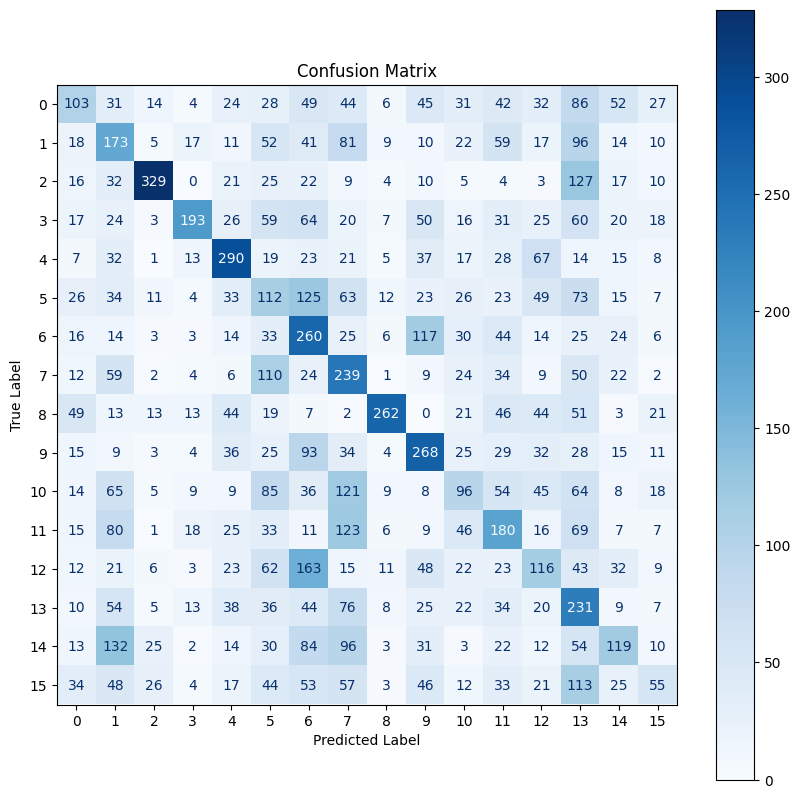

In [31]:


# Train loop
train_loss = 0.0
train_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in train_loader:
        #images, labels = images.to(device), labels.to(device) 
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
train_loss = train_loss / len(train_loader.dataset)
train_accuracy = train_correct.double() / len(train_loader.dataset)
print(f"Test Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Save the model
#torch.save(model_b1_b.state_dict(), './../models/model_efnet_b1.pt')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test Loss: 4.9441, Accuracy: 0.2916


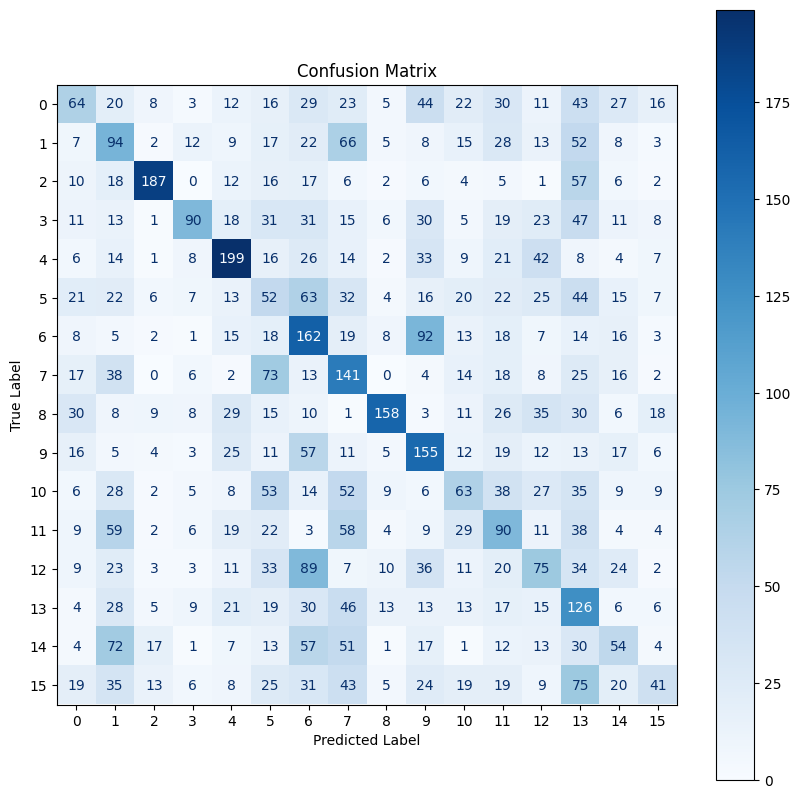

In [32]:


# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        #images, labels = images.to(device), labels.to(device) 
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
#torch.save(model_b1_b.state_dict(), './../models/model_efnet_b1.pt')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test Loss: 5.0762, Accuracy: 0.2863


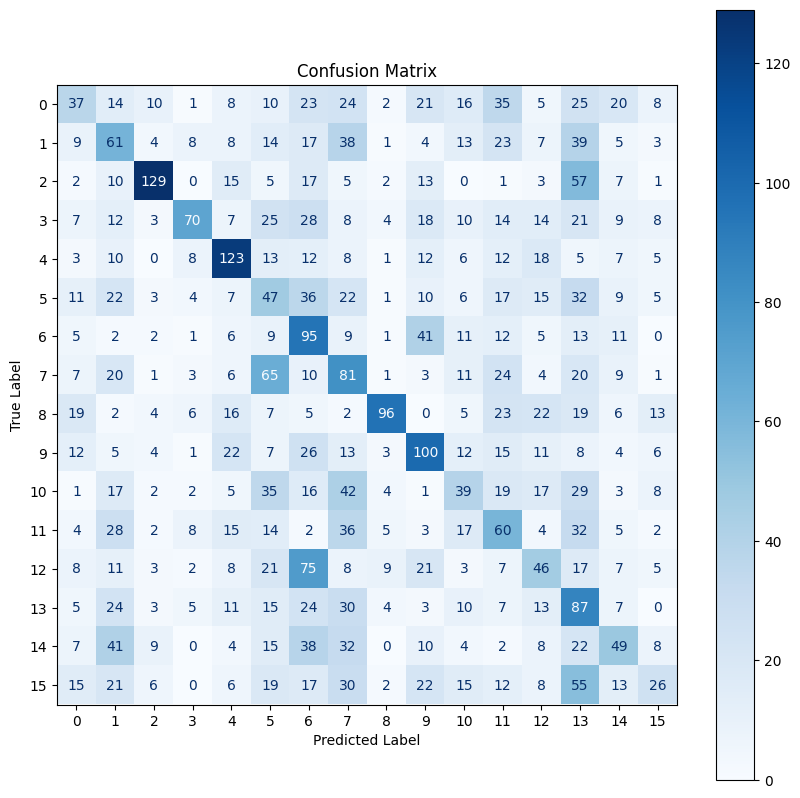

In [33]:


# Validation loop
val_loss = 0.0
val_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in val_loader:
        #images, labels = images.to(device), labels.to(device) 
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Test Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

# Save the model
#torch.save(model_b1_b.state_dict(), './../models/model_efnet_b1.pt')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test other EfficientNet Model

In [3]:
from efficientnet_pytorch import EfficientNet

In [ ]:
torch.cuda.empty_cache()

In [31]:
efficientnet_model = 'b0'

In [32]:
# loading EfficientNet with Linear layer on top
net = EfficientNet.from_pretrained('efficientnet-' + efficientnet_model, num_classes=1000)
num_ftrs = net._fc.in_features
net._fc = nn.Linear(num_ftrs, NUM_CLASSES)
model_b0 = net

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to C:\Users\sofia/.cache\torch\hub\checkpoints\efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 60.8MB/s]


Loaded pretrained weights for efficientnet-b0


In [25]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b1.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [33]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b0.to(device)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [27]:
number_gpus = torch.cuda.device_count()
#batch_size = 16*number_gpus if int(efficientnet_model[1]) < 5 else 8*number_gpus
batch_size = 16*number_gpus
lr_multiplier = 0.2
learning_rate = (lr_multiplier*batch_size)/256

In [28]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model_b1.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.00004)

In [34]:
import torch.optim as optim

# Initialize loss function and optimizer
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b0.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_b0.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model_b0(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"{'Epoch':{epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

KeyboardInterrupt: 

In [38]:
import torch.nn as nn
import torchvision.models as models
torch.cuda.empty_cache()

In [36]:
# Load the pre-trained EfficientNetB0 model
model_b1_b = models.efficientnet_b1(pretrained=True)

# Modify the classifier to fit our number of classes
model_b1_b.classifier[1] = nn.Linear(model_b1_b.classifier[1].in_features, NUM_CLASSES)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b1_b.to(device)


c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to C:\Users\sofia/.cache\torch\hub\checkpoints\efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 31.7MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
# Load the pre-trained EfficientNetB0 model
model_b1_n = models.efficientnet_b1(pretrained=True)

# Modify the classifier to fit our number of classes
model_b1_n.classifier[1] = nn.Linear(model_b1_n.classifier[1].in_features, NUM_CLASSES)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_b1_n.to(device)


c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [49]:
import torch.optim as optim


path = './../models/model_efnet_b1_bigtrain_epoch_'
# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b1_n.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model_b1_n.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model_b1_n(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    path_pt = path + str(epoch) + '.pt'
    path_pth = path + str(epoch) + '.pth'
    torch.save(model_b1_n.state_dict(), path_pt)
    torch.save(model_b1_n.state_dict(), path_pth)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/30, Loss: 1.2328
Epoch 2/30, Loss: 0.8207
Epoch 3/30, Loss: 0.6768
Epoch 4/30, Loss: 0.5590
Epoch 5/30, Loss: 0.4707
Epoch 6/30, Loss: 0.4000
Epoch 7/30, Loss: 0.3311
Epoch 8/30, Loss: 0.2834
Epoch 9/30, Loss: 0.2469
Epoch 10/30, Loss: 0.2121
Epoch 11/30, Loss: 0.1934
Epoch 12/30, Loss: 0.1771
Epoch 13/30, Loss: 0.1574
Epoch 14/30, Loss: 0.1419
Epoch 15/30, Loss: 0.1444
Epoch 16/30, Loss: 0.1274
Epoch 17/30, Loss: 0.1193
Epoch 18/30, Loss: 0.1229
Epoch 19/30, Loss: 0.1088
Epoch 20/30, Loss: 0.0993
Epoch 21/30, Loss: 0.0979
Epoch 22/30, Loss: 0.1022
Epoch 23/30, Loss: 0.0860
Epoch 24/30, Loss: 0.0844
Epoch 25/30, Loss: 0.1019
Epoch 26/30, Loss: 0.0788
Epoch 27/30, Loss: 0.0812
Epoch 28/30, Loss: 0.0724
Epoch 29/30, Loss: 0.0781
Epoch 30/30, Loss: 0.0774


In [50]:
# Validation loop big train
model_b1_n.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model_b1_n(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Validation Loss: 1.3488, Accuracy: 0.7916


Test Loss: 1.2628, Accuracy: 0.7902


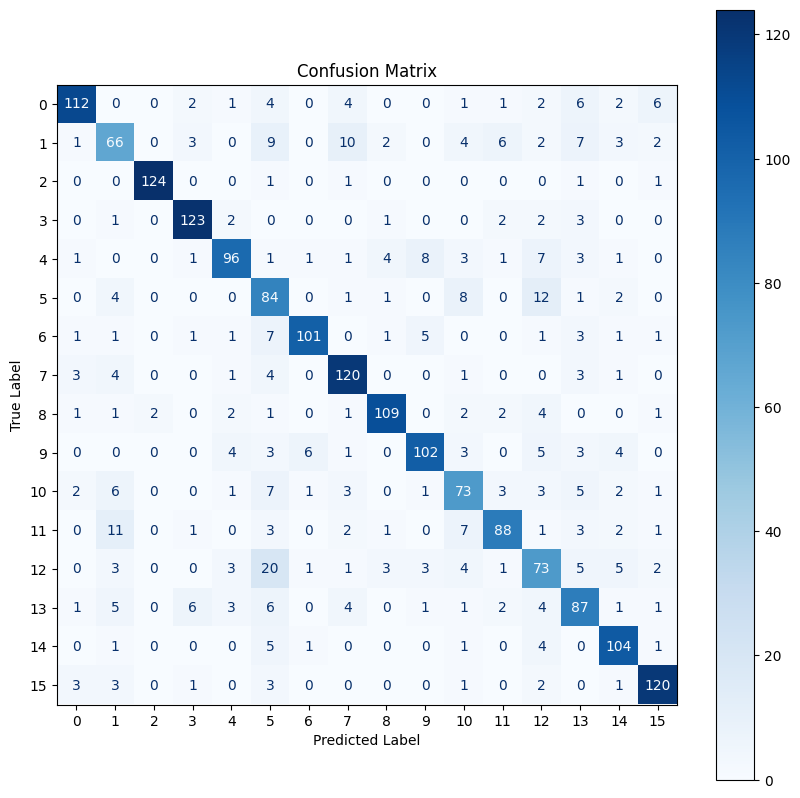

In [51]:
# Testing loop big train
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model_b1_n(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
#torch.save(model_b1_n.state_dict(), './../models/model_efnet_b1.pt')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Validation loop
model_b1_n.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model_b1_n(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Validation Loss: 1.3852, Accuracy: 0.7777


Test Loss: 1.2964, Accuracy: 0.7808


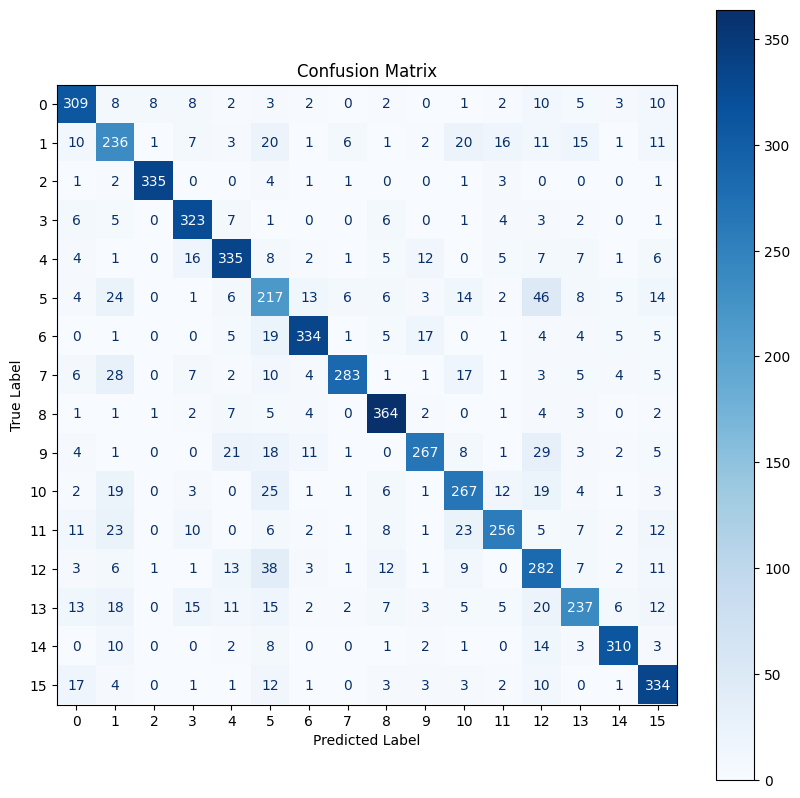

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model_b1_n(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
#torch.save(model_b1_n.state_dict(), './../models/model_efnet_b1.pt')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Validation loop
model_b1_b.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model_b1_b(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Validation Loss: 0.9375, Accuracy: 0.7962


Test Loss: 0.9142, Accuracy: 0.7937


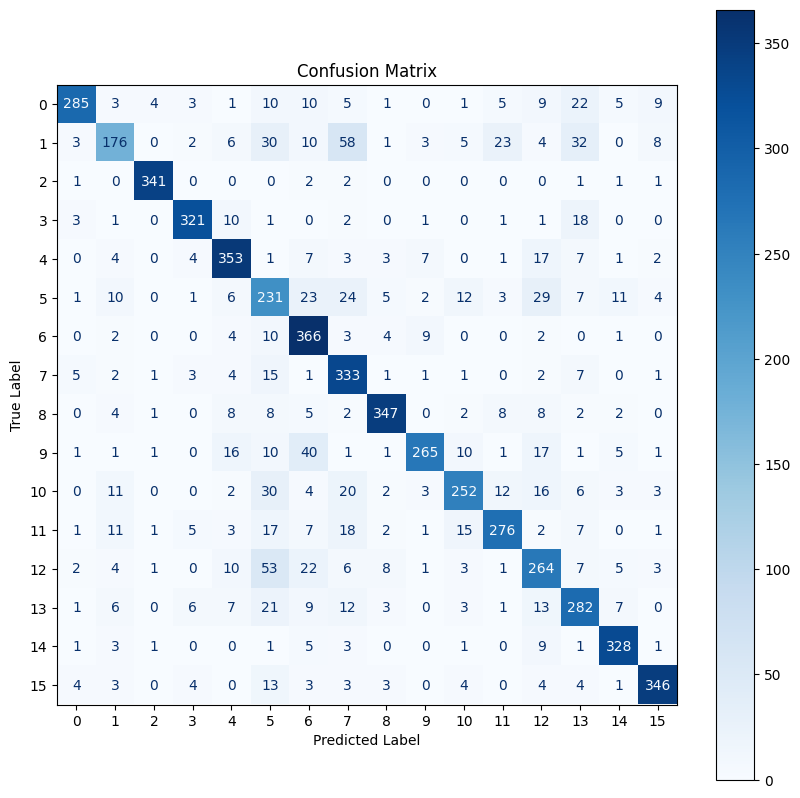

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model_b1_b(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model_b1_b.state_dict(), './../models/model_efnet_b1.pt')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
torch.save(model_b1_b.state_dict(), './../models/model_efnet_b1.pth')

# Load Pre-trained EfficientNet Model


In [5]:
import torch

torch.cuda.empty_cache()

In [6]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'


In [7]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNetB0 model
model = models.efficientnet_b0(pretrained=True)

# Modify the classifier to fit our number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNetB0 model
model_cnn2 = models.efficientnet_b0(pretrained=True)

# Modify the classifier to fit our number of classes
model_cnn2.features[8].append(nn.Conv2d(in_channels = 1280, out_channels = 1280, kernel_size = 3, padding = 1))
model_cnn2.features[8].append(nn.ReLU(inplace=True))
model_cnn2.features[8].append(nn.Dropout(p=0.1))
model_cnn2.features[8].append(nn.Conv2d(in_channels = 1280, out_channels = 1280, kernel_size = 3, padding = 1))
model_cnn2.features[8].append(nn.ReLU(inplace=True))
model_cnn2.features[8].append(nn.Dropout(p=0.1))
model_cnn2.features[8].append(nn.MaxPool2d(kernel_size=2, stride = 2))


model_cnn2.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cnn2.to(device)


c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sofia\Documents\Datascientest\Classification_project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [11]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNetB0 model
model_2 = models.efficientnet_b0(pretrained=True)

# Modify the classifier to fit our number of classes
model_2.classify = nn.Sequential(
            nn.Linear(in_features =model.classifier[1].in_features, out_features = 320),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 320, out_features = 80),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(in_features = 80, out_features = NUM_CLASSES)
                                      
        )
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained EfficientNetB0 model
model_3 = models.efficientnet_b0(pretrained=True)

# Modify the classifier to fit our number of classes
model_3.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features =model.classifier[1].in_features, out_features = 320),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features = 320, out_features = 80),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(in_features = 80, out_features = NUM_CLASSES)
                                      
        )
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_3.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Training Loop with EfficientNet

In [8]:
import torch.optim as optim

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"{'Epoch':{epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 1.4228
Epoch 2/10, Loss: 0.9421
Epoch 3/10, Loss: 0.7808
Epoch 4/10, Loss: 0.6686
Epoch 5/10, Loss: 0.5755
Epoch 6/10, Loss: 0.5022
Epoch 7/10, Loss: 0.4153
Epoch 8/10, Loss: 0.3754
Epoch 9/10, Loss: 0.3142
Epoch 10/10, Loss: 0.2614


In [105]:
import torch.optim as optim

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_2.parameters(), lr=0.001)

# Training loop
num_epochs = 15
for {'Epoch':in range(num_epochs):
    model_2.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"{'Epoch':{epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/15, Loss: 1.5247
Epoch 2/15, Loss: 0.9541
Epoch 3/15, Loss: 0.7778
Epoch 4/15, Loss: 0.6609
Epoch 5/15, Loss: 0.5668
Epoch 6/15, Loss: 0.4856
Epoch 7/15, Loss: 0.4140
Epoch 8/15, Loss: 0.3619
Epoch 9/15, Loss: 0.2840
Epoch 10/15, Loss: 0.2731
Epoch 11/15, Loss: 0.2320
Epoch 12/15, Loss: 0.2136
Epoch 13/15, Loss: 0.1858
Epoch 14/15, Loss: 0.1880
Epoch 15/15, Loss: 0.1534


In [112]:
# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_3.parameters(), lr=0.001)

# Training loop
num_epochs = 15
for {'Epoch':in range(num_epochs):
    model_3.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model_3(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"{'Epoch':{epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/15, Loss: 1.7692
Epoch 2/15, Loss: 1.2792
Epoch 3/15, Loss: 1.0699
Epoch 4/15, Loss: 0.9485
Epoch 5/15, Loss: 0.8500
Epoch 6/15, Loss: 0.7647
Epoch 7/15, Loss: 0.6982
Epoch 8/15, Loss: 0.6307
Epoch 9/15, Loss: 0.5746
Epoch 10/15, Loss: 0.5322
Epoch 11/15, Loss: 0.4856
Epoch 12/15, Loss: 0.4449
Epoch 13/15, Loss: 0.3990
Epoch 14/15, Loss: 0.3724
Epoch 15/15, Loss: 0.3366


In [19]:
import torch.optim as optim

# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for {'Epoch':in range(num_epochs):
    model_cnn2.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        optimizer.zero_grad()
        outputs = model_cnn2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"{'Epoch':{epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 1.9046
Epoch 2/10, Loss: 1.2557
Epoch 3/10, Loss: 1.0130
Epoch 4/10, Loss: 0.9261
Epoch 5/10, Loss: 0.8108
Epoch 6/10, Loss: 0.7398
Epoch 7/10, Loss: 0.6891
Epoch 8/10, Loss: 0.6211
Epoch 9/10, Loss: 0.5613
Epoch 10/10, Loss: 0.5445


Validation Loop

In [9]:
# Validation loop
model.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")


Validation Loss: 0.9261, Accuracy: 0.7764


In [106]:
# Validation loop
model_2.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model_2(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Modele 2 | Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Modele 2 | Validation Loss: 1.0854, Accuracy: 0.7869


In [113]:
# Validation loop
model_3.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model_3(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Modele 3 | Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Modele 3 | Validation Loss: 0.9353, Accuracy: 0.7789


In [20]:
# Validation loop
model_cnn2.eval()
val_loss = 0.0
val_correct = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        outputs = model_cnn2(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
val_loss = val_loss / len(val_loader.dataset)
val_accuracy = val_correct.double() / len(val_loader.dataset)
print(f"Modele 3 | Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

Modele 3 | Validation Loss: 0.8215, Accuracy: 0.7787


Test Loss: 0.9819, Accuracy: 0.7725


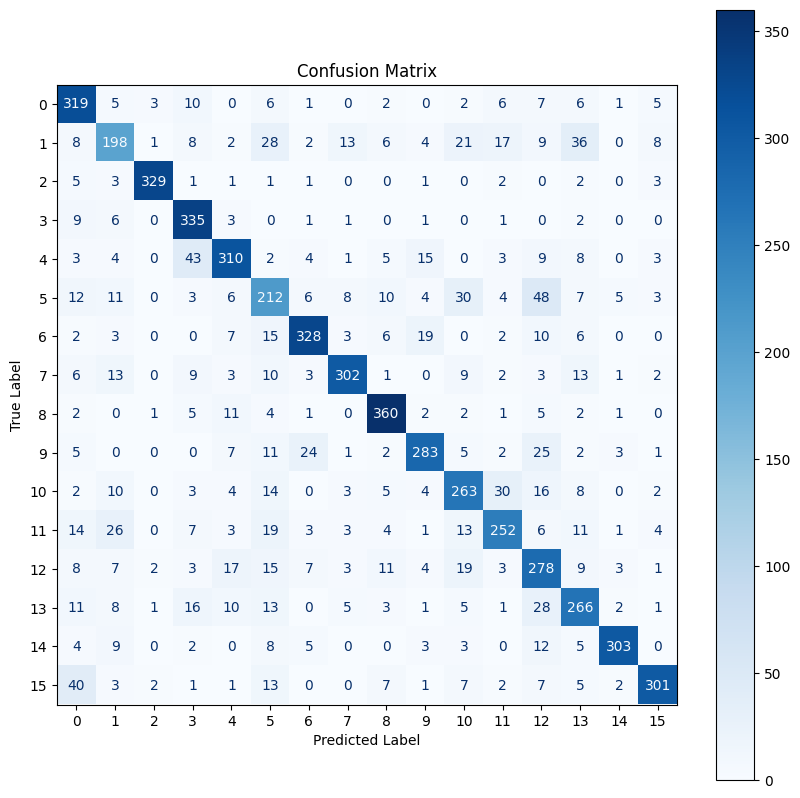

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), 'model.pth')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test Loss: 1.0743, Accuracy: 0.7825


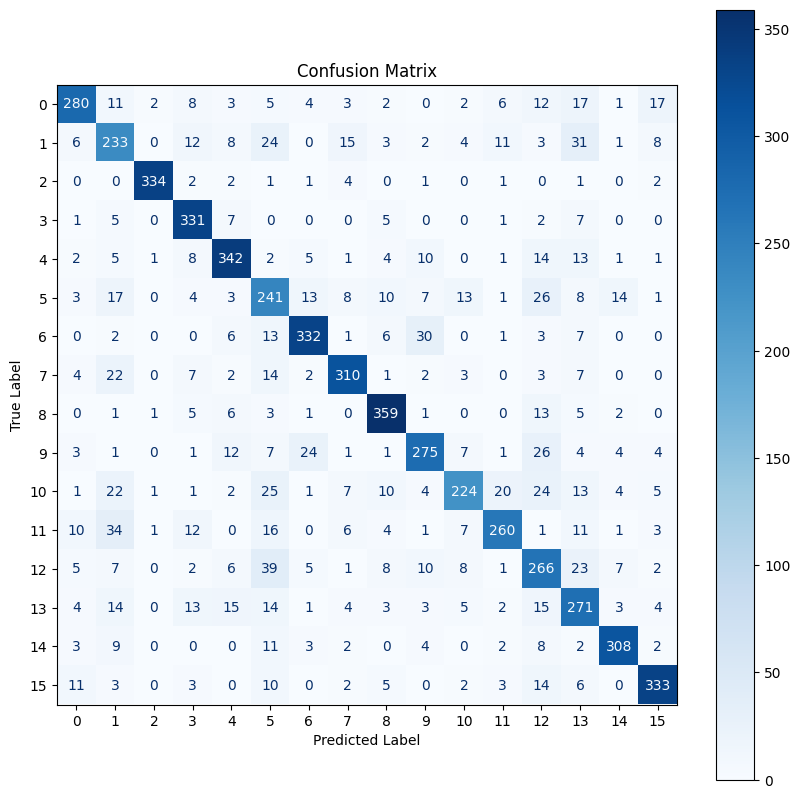

In [107]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model_2(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model_2.state_dict(), './../models/model_efnet_2.pth')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Test Loss: 0.9966, Accuracy: 0.7614


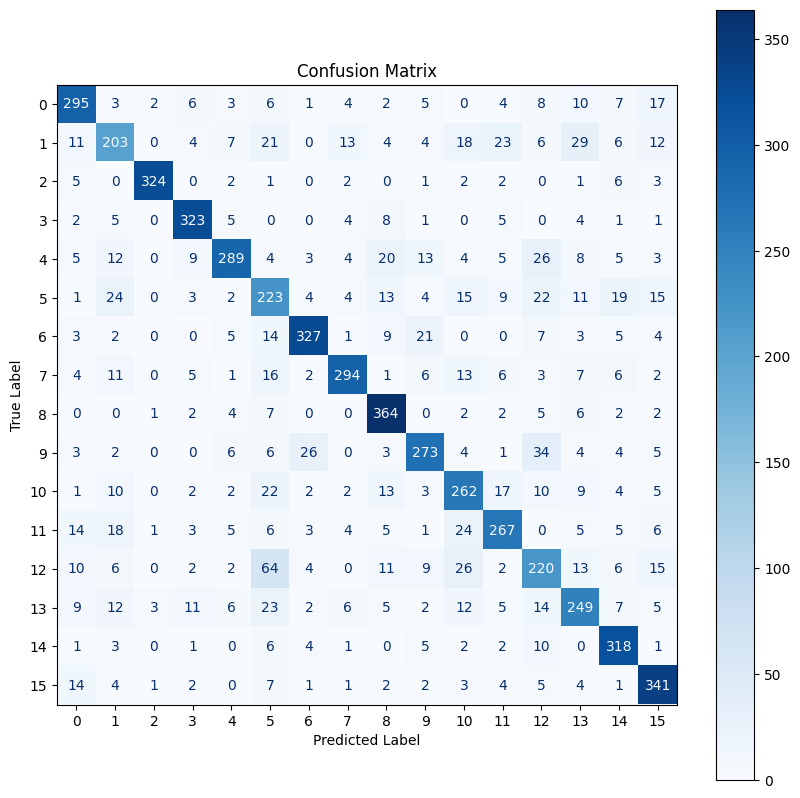

In [114]:
# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model_3(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model_3.state_dict(), './../models/model_efnet_3.pth')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Testing Loop

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model.state_dict(), 'model.pth')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'model' is not defined

Test Loss: 0.8526, Accuracy: 0.7770


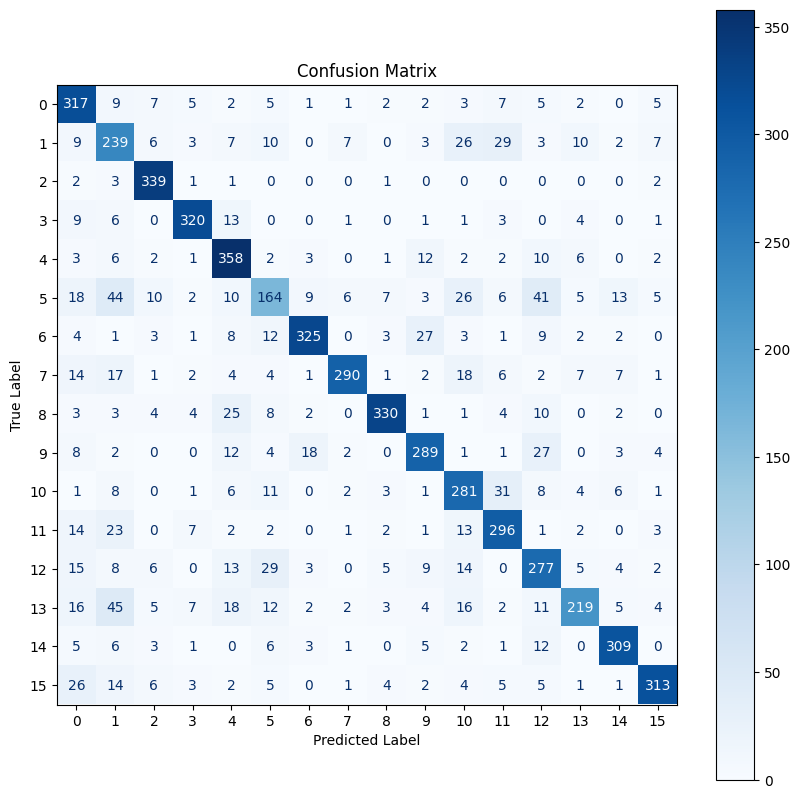

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Testing loop
test_loss = 0.0
test_correct = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device) 
        outputs = model_cnn2(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
test_loss = test_loss / len(test_loader.dataset)
test_accuracy = test_correct.double() / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

# Save the model
torch.save(model_cnn2.state_dict(), './../models/model_efnet_augmented.pth')
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUM_CLASSES)])

# Plot confusion matrix with axis labels
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

Load pretrained model

In [ ]:
# Load the pre-trained EfficientNetB0 model
model = models.efficientnet_b0(pretrained=False)

model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)

# Load the saved state dictionary
model.load_state_dict(torch.load('model.pth'))


<All keys matched successfully>

 # Modele evaluation

In [ ]:
cnn_model = models.efficientnet_b1()
cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
cnn_model.load_state_dict(torch.load('./../models/model_efnet_b1_bigtrain_epoch_27.pth'))

In [114]:

path = './../models/model_efnet_b1_bigtrain_epoch_'
# Initialize loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_b1_n.parameters(), lr=0.001)
train_values = {}
val_values = {}
# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    print('epoch :',epoch)
    cnn_model = models.efficientnet_b1()
    cnn_model.classifier[1] = nn.Linear(cnn_model.classifier[1].in_features, 16)
    cnn_model.load_state_dict(torch.load('./../models/model_efnet_b1_bigtrain_epoch_'+str(epoch)+'.pth'))
    train_loss = 0.0
    train_correct = 0.0
    val_loss = 0.0
    val_correct = 0.0
    for images, labels in train_loader:
        #images, labels = images.to(device), labels.to(device) 
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct.double() / len(train_loader.dataset)
    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    train_values[epoch] = {'loss':train_loss, 'accuracy': train_accuracy}

    for images, labels in val_loader:
        #images, labels = images.to(device), labels.to(device) 
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += torch.sum(preds == labels.data)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = val_correct.double() / len(val_loader.dataset)
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}")
    val_values[epoch] = {'loss':val_loss, 'accuracy': val_accuracy}


epoch : 0
Train Loss: 0.8280, Accuracy: 0.7545
Val Loss: 0.9971, Accuracy: 0.7036
epoch : 1
Train Loss: 0.6734, Accuracy: 0.7987
Val Loss: 0.9736, Accuracy: 0.7151
epoch : 2
Train Loss: 0.5184, Accuracy: 0.8414
Val Loss: 0.8629, Accuracy: 0.7571
epoch : 3
Train Loss: 0.4485, Accuracy: 0.8635
Val Loss: 0.8536, Accuracy: 0.7636
epoch : 4
Train Loss: 0.3317, Accuracy: 0.9004
Val Loss: 0.8259, Accuracy: 0.7661
epoch : 5
Train Loss: 0.2866, Accuracy: 0.9142
Val Loss: 0.8783, Accuracy: 0.7691
epoch : 6
Train Loss: 0.2767, Accuracy: 0.9149
Val Loss: 0.9294, Accuracy: 0.7511
epoch : 7
Train Loss: 0.1929, Accuracy: 0.9369
Val Loss: 0.9312, Accuracy: 0.7766
epoch : 8
Train Loss: 0.1773, Accuracy: 0.9454
Val Loss: 0.9724, Accuracy: 0.7596
epoch : 9
Train Loss: 0.1513, Accuracy: 0.9544
Val Loss: 1.0647, Accuracy: 0.7641
epoch : 10
Train Loss: 0.1409, Accuracy: 0.9556
Val Loss: 1.0597, Accuracy: 0.7586
epoch : 11
Train Loss: 0.1212, Accuracy: 0.9602
Val Loss: 1.0578, Accuracy: 0.7701
epoch : 12
Tra

In [115]:
train_values

{0: {'loss': 0.8280370424992735,
  'accuracy': tensor(0.7545, dtype=torch.float64)},
 1: {'loss': 0.6734336764923251,
  'accuracy': tensor(0.7987, dtype=torch.float64)},
 2: {'loss': 0.5184027541772205,
  'accuracy': tensor(0.8414, dtype=torch.float64)},
 3: {'loss': 0.4484689789706696,
  'accuracy': tensor(0.8635, dtype=torch.float64)},
 4: {'loss': 0.3317373516524312,
  'accuracy': tensor(0.9004, dtype=torch.float64)},
 5: {'loss': 0.28661899354058507,
  'accuracy': tensor(0.9142, dtype=torch.float64)},
 6: {'loss': 0.27672279269887956,
  'accuracy': tensor(0.9149, dtype=torch.float64)},
 7: {'loss': 0.19288914122828357,
  'accuracy': tensor(0.9369, dtype=torch.float64)},
 8: {'loss': 0.17734217896821156,
  'accuracy': tensor(0.9454, dtype=torch.float64)},
 9: {'loss': 0.15127481592113215,
  'accuracy': tensor(0.9544, dtype=torch.float64)},
 10: {'loss': 0.14085559282673357,
  'accuracy': tensor(0.9556, dtype=torch.float64)},
 11: {'loss': 0.12121886372443613,
  'accuracy': tensor(0.

In [55]:
val_values

{0: {'loss': 1.0127223388298408,
  'accuracy': tensor(0.6918, dtype=torch.float64)},
 1: {'loss': 0.9738203389542205,
  'accuracy': tensor(0.7183, dtype=torch.float64)},
 2: {'loss': 0.8666305903430942,
  'accuracy': tensor(0.7587, dtype=torch.float64)},
 3: {'loss': 0.8528191932550558,
  'accuracy': tensor(0.7642, dtype=torch.float64)},
 4: {'loss': 0.8219928472311228,
  'accuracy': tensor(0.7702, dtype=torch.float64)},
 5: {'loss': 0.8909655497981595,
  'accuracy': tensor(0.7647, dtype=torch.float64)},
 6: {'loss': 0.9346871254565594,
  'accuracy': tensor(0.7547, dtype=torch.float64)},
 7: {'loss': 0.9568021791679161,
  'accuracy': tensor(0.7682, dtype=torch.float64)},
 8: {'loss': 0.9727770465237278,
  'accuracy': tensor(0.7617, dtype=torch.float64)},
 9: {'loss': 1.0780845558964884,
  'accuracy': tensor(0.7647, dtype=torch.float64)},
 10: {'loss': 1.0774207798155633,
  'accuracy': tensor(0.7567, dtype=torch.float64)},
 11: {'loss': 1.0600229993566765,
  'accuracy': tensor(0.7742, d

In [68]:
df_val_values = pd.DataFrame(val_values)
df_train_values = pd.DataFrame(train_values)

In [69]:
df_val_values = df_val_values.T
df_train_values = df_train_values.T

In [73]:
df_train_values

,loss,accuracy
0,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
1,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
2,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
3,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
4,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
5,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
6,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
7,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
8,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."
9,0.000631,"tensor(0.7902, device='cuda:0', dtype=torch.fl..."


In [116]:
df_val_values_b1 = pd.DataFrame(val_values)
df_train_values_b1 = pd.DataFrame(train_values)
df_val_values_b1 = df_val_values_b1.T
df_train_values_b1 = df_train_values_b1.T

In [117]:
df_val_values_b1['accuracy_val'] = df_val_values_b1['accuracy'].apply(lambda x: x.numpy())
df_train_values_b1['accuracy_val'] = df_train_values_b1['accuracy'].apply(lambda x: x.numpy())

In [118]:
df_val_values_b1

,loss,accuracy,accuracy_val
0,0.997136,"tensor(0.7036, dtype=torch.float64)",0.703648
1,0.973557,"tensor(0.7151, dtype=torch.float64)",0.715142
2,0.862944,"tensor(0.7571, dtype=torch.float64)",0.757121
3,0.853576,"tensor(0.7636, dtype=torch.float64)",0.763618
4,0.825859,"tensor(0.7661, dtype=torch.float64)",0.766117
5,0.878301,"tensor(0.7691, dtype=torch.float64)",0.769115
6,0.929383,"tensor(0.7511, dtype=torch.float64)",0.751124
7,0.931158,"tensor(0.7766, dtype=torch.float64)",0.776612
8,0.972438,"tensor(0.7596, dtype=torch.float64)",0.759620
9,1.0647,"tensor(0.7641, dtype=torch.float64)",0.764118


In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

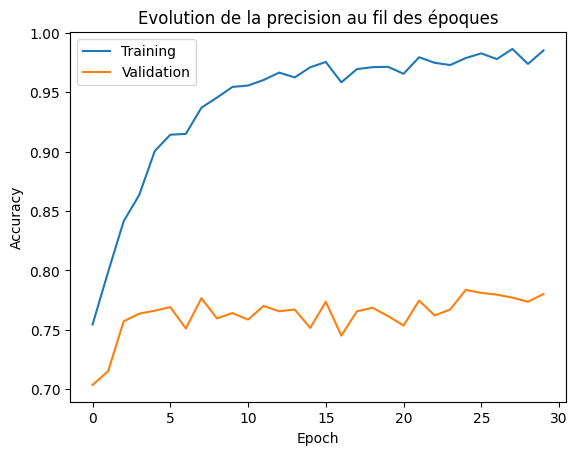

In [124]:
sns.lineplot(df_train_values_b1['accuracy_val'], label='Training')
sns.lineplot(df_val_values_b1['accuracy_val'], label='Validation')

plt.title('Evolution de la precision au fil des époques')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

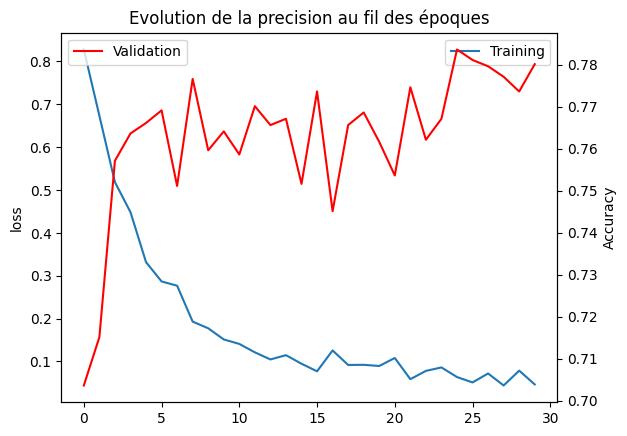

In [138]:
sns.lineplot(df_train_values_b1['loss'], label='Training')
ax2 = plt.twinx()
sns.lineplot(df_val_values_b1['accuracy_val'], label='Validation', ax = ax2, color ='r')

plt.title('Evolution de la precision au fil des époques')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

Text(0.5, 1.0, 'Evolution de la precision au fil des époques')

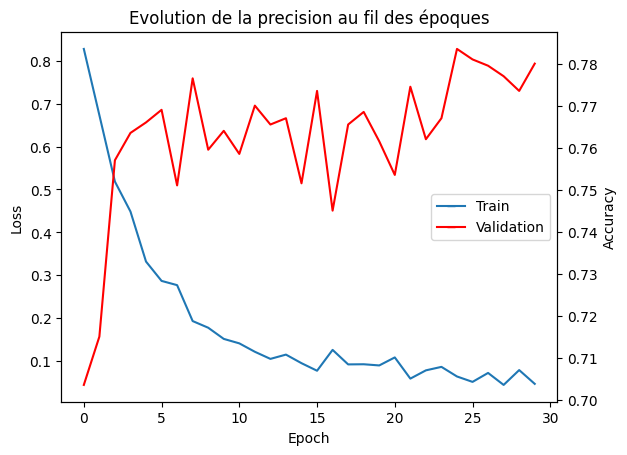

In [143]:
from matplotlib.lines import Line2D
    
g = sns.lineplot(data=df_train_values_b1['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
sns.lineplot(data=df_val_values_b1['accuracy_val'], color="r", ax=g.axes.twinx())
g.legend(handles=[Line2D([], [], marker='_',  label='Train'), Line2D([], [], marker='_', color="r", label='Validation')])
plt.ylabel('Accuracy')
sns.move_legend(g, "center right")
plt.title('Evolution de la precision au fil des époques')

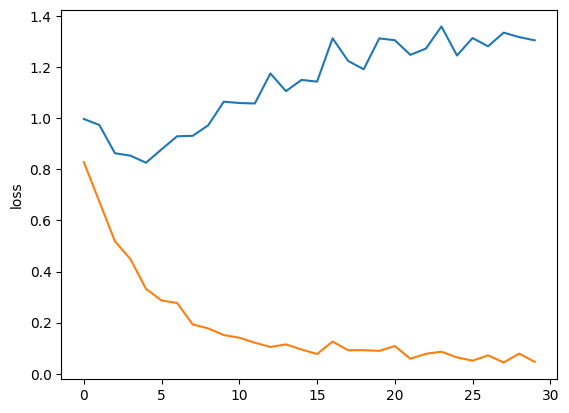

In [121]:
sns.lineplot(df_val_values_b1['loss'])
sns.lineplot(df_train_values_b1['loss'])
plt.title('Evolution ')
plt.show();

<Axes: ylabel='loss'>

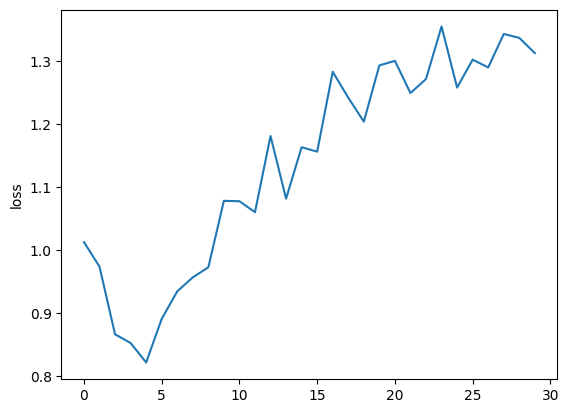

In [67]:
sns.lineplot(df_val_values['loss'])

In [86]:
#B1_big_train

b1_big_train = [{'Epoch': 1, 'Loss': 1.2328},
{'Epoch': 2, 'Loss': 0.8207},
{'Epoch': 3, 'Loss': 0.6768},
{'Epoch': 4, 'Loss': 0.5590},
{'Epoch': 5, 'Loss': 0.4707},
{'Epoch': 6, 'Loss': 0.4000},
{'Epoch': 7, 'Loss': 0.3311},
{'Epoch': 8, 'Loss': 0.2834},
{'Epoch': 9, 'Loss': 0.2469},
{'Epoch': 10, 'Loss': 0.2121},
{'Epoch': 11, 'Loss': 0.1934},
{'Epoch': 12, 'Loss': 0.1771},
{'Epoch': 13, 'Loss': 0.1574},
{'Epoch': 14, 'Loss': 0.1419},
{'Epoch': 15, 'Loss': 0.1444},
{'Epoch': 16, 'Loss': 0.1274},
{'Epoch': 17, 'Loss': 0.1193},
{'Epoch': 18, 'Loss': 0.1229},
{'Epoch': 19, 'Loss': 0.1088},
{'Epoch': 20, 'Loss': 0.0993},
{'Epoch': 21, 'Loss': 0.0979},
{'Epoch': 22, 'Loss': 0.1022},
{'Epoch': 23, 'Loss': 0.0860},
{'Epoch': 24, 'Loss': 0.0844},
{'Epoch': 25, 'Loss': 0.1019},
{'Epoch': 26, 'Loss': 0.0788},
{'Epoch': 27, 'Loss': 0.0812},
{'Epoch': 28, 'Loss': 0.0724},
{'Epoch': 29, 'Loss': 0.0781},
{'Epoch': 30, 'Loss': 0.0774}]

In [87]:
#B0 train
b0 = [{'Epoch':1, 'Loss': 1.4228},
{'Epoch':2, 'Loss': 0.9421},
{'Epoch':3, 'Loss': 0.7808},
{'Epoch':4, 'Loss': 0.6686},
{'Epoch':5, 'Loss': 0.5755},
{'Epoch':6, 'Loss': 0.5022},
{'Epoch':7, 'Loss': 0.4153},
{'Epoch':8, 'Loss': 0.3754},
{'Epoch':9, 'Loss': 0.3142},
{'Epoch':10, 'Loss': 0.2614}]

In [91]:
#b0 with extrat linear 
    
b0_extra_linear = [ {'Epoch':1, 'Loss': 1.5247},
{'Epoch':2, 'Loss': 0.9541},
{'Epoch':3, 'Loss': 0.7778},
{'Epoch':4, 'Loss': 0.6609},
{'Epoch':5, 'Loss': 0.5668},
{'Epoch':6, 'Loss': 0.4856},
{'Epoch':7, 'Loss': 0.4140},
{'Epoch':8, 'Loss': 0.3619},
{'Epoch':9, 'Loss': 0.2840},
{'Epoch':10, 'Loss': 0.2731},
{'Epoch':11, 'Loss': 0.2320},
{'Epoch':12, 'Loss': 0.2136},
{'Epoch':13, 'Loss': 0.1858},
{'Epoch':14, 'Loss': 0.1880},
{'Epoch':15, 'Loss': 0.1534}]

In [92]:
#b0 with extra linear 

b0_extra_linear_2 = [{'Epoch':1, 'Loss': 1.7692},
{'Epoch':2, 'Loss': 1.2792},
{'Epoch':3, 'Loss': 1.0699},
{'Epoch':4, 'Loss': 0.9485},
{'Epoch':5, 'Loss': 0.8500},
{'Epoch':6, 'Loss': 0.7647},
{'Epoch':7, 'Loss': 0.6982},
{'Epoch':8, 'Loss': 0.6307},
{'Epoch':9, 'Loss': 0.5746},
{'Epoch':10, 'Loss': 0.5322},
{'Epoch':11, 'Loss': 0.4856},
{'Epoch':12, 'Loss': 0.4449},
{'Epoch':13, 'Loss': 0.3990},
{'Epoch':14, 'Loss': 0.3724},
{'Epoch':15, 'Loss': 0.3366}]

In [93]:
#Model b0 with extrat CNN layers

b0_cnn_layer = [{'Epoch' :1, 'Loss': 1.9046},
                {'Epoch' :2, 'Loss': 1.2557},
                {'Epoch' :3, 'Loss': 1.0130},
                {'Epoch' :4, 'Loss': 0.9261},
                {'Epoch' :5, 'Loss': 0.8108},
                {'Epoch' :6, 'Loss': 0.7398},
                {'Epoch' :7, 'Loss': 0.6891},
                {'Epoch' :8, 'Loss': 0.6211},
                {'Epoch' :9, 'Loss': 0.5613},
                {'Epoch' :10, 'Loss': 0.5445}]

In [94]:
df_b0_cnn_layer = pd.DataFrame(b0_cnn_layer)
df_b0_extra_linear = pd.DataFrame(b0_extra_linear)
df_b0_extra_linear_2 = pd.DataFrame(b0_extra_linear_2)
df_b0 = pd.DataFrame(b0)
df_b1 = pd.DataFrame(b1_big_train)

In [83]:
df_b0_cnn_layer

,Epoch,Loss
0,1,1.9046
1,2,1.2557
2,3,1.0130
3,4,0.9261
4,5,0.8108
5,6,0.7398
6,7,0.6891
7,8,0.6211
8,9,0.5613
9,10,0.5445


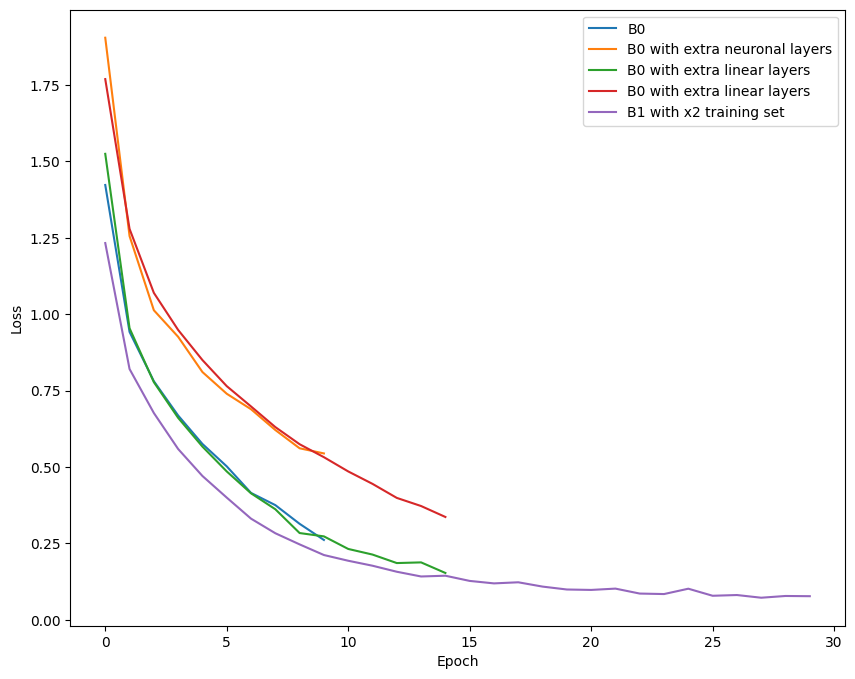

In [112]:
plt.figure(figsize = (10,8))
sns.lineplot(df_b0['Loss'], label ='B0')

sns.lineplot(df_b0_cnn_layer['Loss'], label ='B0 with extra neuronal layers')
sns.lineplot(df_b0_extra_linear['Loss'], label ='B0 with extra linear layers')
sns.lineplot(df_b0_extra_linear_2['Loss'], label ='B0 with extra linear layers')

sns.lineplot(df_b1['Loss'], label ='B1 with x2 training set')
plt.xlabel('Epoch')
#plt.yscale('log')
plt.legend()
plt.show();